In [1]:
import tdt
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sig

%run fx4assembly.py
%run fx4behavior.py
%run fx4makingsnips.py

%matplotlib inline

In [14]:
test_sessions = metafile2sessions("..\\data\\test_ppp3.xlsx",
                                  "..\\data\\test",
                                  "..\\data\\",
                                  "..\\output\\")

In [15]:
ppp4_sessions = metafile2sessions('D:\\DA_and_Reward\\gc214\\PPP4\\PPP4.xlsx',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\PPP4_metafile',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\tdtfiles\\',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\output\\',
                                  sheetname='PPP4_metafile')

In [16]:
test_sessions
# s = test_sessions['PPP1-7_s10'] # for testing PPP1
s = test_sessions['PPP3-2_s10'] # for testing PPP3

# s = ppp4_sessions['PPP4-8_s10'] # for testing different rats in PPP4

s.loaddata()
s.data_filt = correctforbaseline(s.data, s.dataUV)
s.setticks()
s.time2samples()
s.check4events()
s.setbottlecolors()

read from t=0s to t=2159.68s
read from t=0s to t=2159.68s
read from t=0s to t=2159.68s
read from t=0s to t=2159.68s


In [17]:
try:
    s.left['lickdata'] = lickCalc(s.left['licks'],
                      offset = s.left['licks_off'],
                      burstThreshold = 0.50)
except IndexError:
    s.left['lickdata'] = 'none'
    print('No left licks')
    
try:
    s.right['lickdata'] = lickCalc(s.right['licks'],
              offset = s.right['licks_off'],
              burstThreshold = 0.50)
except IndexError:
    s.right['lickdata'] = 'none'
    print('No right licks')

[376.15501312000004, 401.9494912, 406.88746496, 444.33178624, 540.46507008, 623.75460864, 624.9545728, 663.95488256, 679.36468992, 790.18278912, 861.0874982400001, 913.432576, 931.85818624, 1002.1090099200001, 1085.31253248, 1114.94299648, 1118.34300416, 1136.05656576, 1265.12234496, 1287.37001472, 1389.9341824, 1423.95162624, 1487.34558208, 1524.75877376, 1574.26614272, 1590.1178265600001, 1620.82521088, 1672.71235584, 1719.73246976, 1802.67401216, 1874.56765952, 1900.4563456, 1916.19416064, 1947.0524416, 1982.7569459200001, 2039.5819008, 2042.08996352]
[ 295.26540288  295.54540544  295.6804096  ... 2099.08596736 2099.236864
 2099.38300928]
[353.52625152, 478.9092352, 515.06249728, 561.35467008, 593.86314752, 701.61022976, 735.29278464, 812.15537152, 838.483968, 889.4960435200001, 965.33364736, 1028.11058176, 1049.09422592, 1170.22113792, 1210.5862348800001, 1246.88269312, 1318.035456, 1323.07533824, 1345.0100736, 1359.47075584, 1361.7946624, 1455.02109696, 1458.10096128, 1459.9100825

In [18]:
bins = 300

s.randomevents = makerandomevents(120, max(s.tick)-120)
s.bgTrials, s.pps = snipper(s.data, s.randomevents,
                                t2sMap = s.t2sMap, fs = s.fs, bins=bins)

In [29]:
for side in [s.left, s.right]:   
    if side['exist'] == True:
        side['snips_sipper'] = mastersnipper(s, side['sipper'], peak_between_time=[0, 5],
                                             latency_events=side['lickdata']['rStart'],
                                             latency_direction='post')
        side['snips_licks'] = mastersnipper(s, side['lickdata']['rStart'], peak_between_time=[0, 2],
                                            latency_events=side['sipper'],
                                            latency_direction='pre')
                                           
        try:
            forced_licks = [licks for licks in side['lickdata']['rStart'] if licks in side['licks-forced']]
            side['snips_licks_forced'] = mastersnipper(s, forced_licks, peak_between_time=[0, 2],
                                                       latency_events=side['sipper'],
                                                       latency_direction='pre')
        except KeyError:
            pass
        try:
            side['lats'] = latencyCalc(side['lickdata']['licks'], side['sipper'], cueoff=side['sipper_off'], lag=0)
        except TypeError:
            print('Cannot work out latencies as there are lick and/or sipper values missing.')
            side['lats'] = []
s.side2subs()

22 events to analyze.
0 noise trials removed
34 events to analyze.
0 noise trials removed
22 events to analyze.
0 noise trials removed
22 events to analyze.
0 noise trials removed
33 events to analyze.
0 noise trials removed
21 events to analyze.
0 noise trials removed


<Figure size 432x288 with 0 Axes>

In [ ]:
def mastersnipper(x, events,
                  bins=300,
                  preTrial=10,
                  trialLength=30,
                  threshold=10):
    if len(events) < 1:
        print('Cannot find any events. All outputs will be empty.')
        blueTrials, uvTrials, noiseindex, diffTrials, peak, latency = ([] for i in range(5))
    else:
        blueTrials,_ = snipper(x.data, events,
                                   t2sMap=x.t2sMap,
                                   fs=x.fs,
                                   bins=bins,
                                   preTrial=preTrial,
                                   trialLength=trialLength)
        uvTrials,_ = snipper(x.datauv, events,
                                   t2sMap=x.t2sMap,
                                   fs=x.fs,
                                   bins=bins,
                                   preTrial=preTrial,
                                   trialLength=trialLength)
        filtTrials,_ = snipper(x.datafilt, events,
                                   t2sMap=x.t2sMap,
                                   fs=x.fs,
                                   bins=bins,
                                   preTrial=preTrial,
                                   trialLength=trialLength,
                                   adjustBaseline = False)
        
        filtTrials_z = np.asarray(zscore(filtTrials))
        
        bgMAD = findnoise(x.data, x.randomevents,
                              t2sMap=x.t2sMap, fs=x.fs, bins=bins,
                              method='sum')        
        sigSum = [np.sum(abs(i)) for i in blueTrials]
        sigSD = [np.std(i) for i in blueTrials]
        noiseindex = [i > bgMAD*threshold for i in sigSum]

        output = {}
        output['blue'] = blueTrials
        output['uv'] = uvTrials
        output['filt'] = filtTrials
        output['filt_z'] = filtTrials_z
        output['noise'] = noiseindex
        
        return output

In [20]:
s.cas['snips_licks_forced'].keys()

dict_keys(['blue', 'uv', 'filt', 'filt_z', 'filt_z_adjBL', 'filt_avg', 'filt_avg_z', 'noise', 'peak', 'latency'])

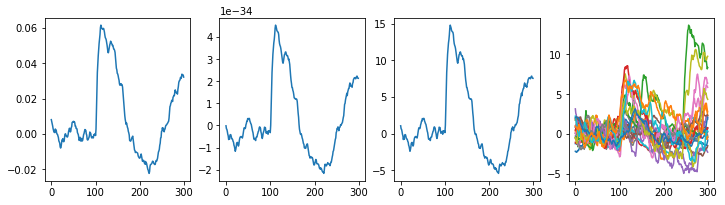

In [30]:
f, ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot(np.mean(s.cas['snips_sipper']['blue'], axis=0))
ax[1].plot(np.mean(s.cas['snips_sipper']['filt'], axis=0))
ax[2].plot(s.cas['snips_sipper']['filt_avg_z'])
for trial in s.cas['snips_sipper']['filt_z']:
    ax[3].plot(trial)


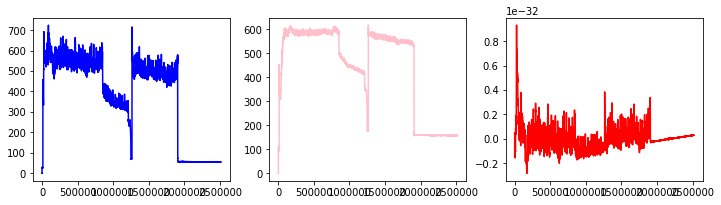

In [8]:
f, ax = plt.subplots(ncols=3, figsize=(12, 3))
ax[0].plot(s.data, color='blue')
ax[1].plot(s.dataUV, color='pink')
ax[2].plot(s.data_filt, color='red')



In [ ]:
# side=s.right
# side['snips_sipper'] = mastersnipper_filt(s, side['sipper'], peak_between_time=[0, 5])
# s.side2subs()

In [ ]:
# ax[0].plot(np.mean(s.cas['snips_sipper']['filt'], axis=0))
# ax[1].plot(np.mean(s.cas['snips_sipper']['filt_z'], axis=0))
# ax[2].plot(np.mean(s.cas['snips_sipper']['filt_z_adjBL'], axis=0))
# ax[3].plot(s.cas['snips_sipper']['filt_avg'])

    
for blue, uv, diff, filt, filt_z in zip(s.cas['snips_sipper']['blue'],
                                        s.cas['snips_sipper']['uv'],
                                        s.cas['snips_sipper']['diff'],
                                        s.cas['snips_sipper']['filt'],
                                        s.cas['snips_sipper']['filt_z']):
    f, ax = plt.subplots(ncols=4, figsize=(12,4))
    ax[0].plot(blue)
    ax[0].plot(uv)
    ax[1].plot(diff)
    ax[2].plot(filt)
    ax[3].plot(filt_z)

In [ ]:
s.cas['snips_sipper']['blue']

In [ ]:
s.cas['snips_licks_forced'].keys()

In [ ]:
s.ttls

In [ ]:
# how do we work out if there are n consecutive values that exceed a certain threshold (z_thresh) in a certain time window (e.g. 0-5 s after event)?
for filt_z in s.cas['snips_sipper']['filt_z']:
#     f, ax = plt.subplots()
#     ax.plot(filt_z)
    thresh = 2.5
    signifarray = [1 if val > thresh else 0 for val in filt_z[100:151]]
    
    
print(signifarray)

In [ ]:
diff = np.diff(signifarray)
diff.index(-1)

In [ ]:
np?